# Behavior of the AI

In the beginning of each trial, the AI is "internally" prepared to attack.  If the player attacks early in the trial, the AI is prepared to parry and will likely successfully parry the attack. As time goes on the AI will begin to prepare to attack -- which makes the reaction time distribution for parrying farther from zero. This same pattern is repeated every trial.

## The stochasticity between experiments  
The time where the AI plans on attacking is chosen at the beginning of the trial and doesn't depend on the player's previous actions. Instead, it depends on the AI's previous attack times. The previous attack time is adjusted by a value from a beta distribution. Due to the independence of the attack time from player inputs, we can generate a set of attack times for an entire experiment.

Populating the interactive namespace from numpy and matplotlib


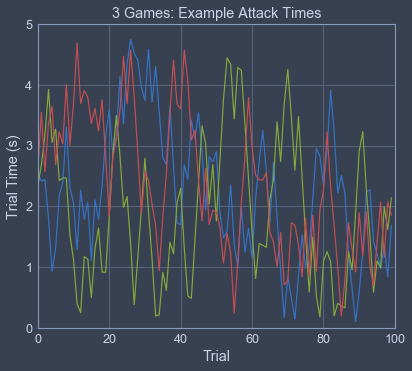

In [3]:
# Set up
import numpy as np
import matplotlib.pyplot as plt
%pylab inline

from jupyterthemes import jtplot
import seaborn as sns
jtplot.style()


# Initialize values
trial_length = 5. # seconds
trial_midpoint = trial_length / 2
initial_attack_sd = 0.2
number_of_trials = 100
max_rt = 0.1
jump_scale = 1 # max +- seconds jump between consecutive trials


# Define function to get intial attack time and iterate over trials to adjust time according to samples from a beta distribution
def get_attack_times():
    
    initial_attack_time, = np.random.normal(trial_midpoint,initial_attack_sd,1)
    attack_time_shifts = (np.random.beta(0.5,0.5,number_of_trials) - .5) * 2* jump_scale
    attack_times = np.zeros(number_of_trials)
    attack_times[0] = initial_attack_time
    
    for trialnum in range(1, number_of_trials):
        last_attack_time = attack_times[trialnum - 1]
        this_update = attack_time_shifts[trialnum]
        
        next_attack_time = last_attack_time + this_update
        if next_attack_time > trial_length - max_rt or next_attack_time < 0 + max_rt: 
            # The one 'impure' adjustment made: if the shift causes the attack time to veer outside the trial boundaries, reverse the direction.
            next_attack_time = last_attack_time - this_update
            
        attack_times[trialnum] = next_attack_time
        
    return attack_times


# Let's visualize the AI's attack times for 3 separate games
for example_num in range(3):
    plt.plot(get_attack_times());
    plt.xlim([0,100]); plt.ylim([0,5])
    plt.xlabel('Trial'); ylabel('Trial Time (s)')
    plt.yticks(np.linspace(0,5,6));
    title('3 Games: Example Attack Times')
    
# We should see that the AI's 'plan' varies over time and between experiments.

## The distribution of updates

Each trial will have an attack time planned based on the previous trial plus a random shift. We can see the distribution of those shifts if we simulate many games and look at the differences in attack time.



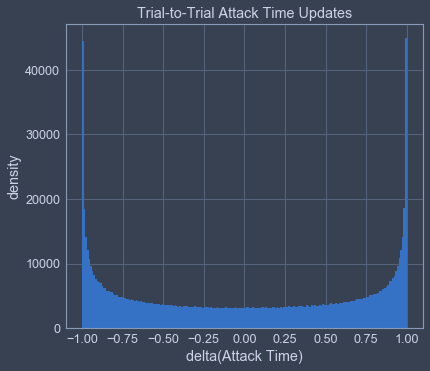

In [4]:
number_of_simulations = 10000

simulated_diffs = []

#  Get the jumps between attack times
for simulation_num in range(number_of_simulations):
    simulated_diffs.append(np.diff(get_attack_times()))

# Bin the differences to show the (beta) distribution from which updates occur
plt.hist(np.concatenate(simulated_diffs), bins=200);
xlabel('delta(Attack Time)');
ylabel('density');
title('Trial-to-Trial Attack Time Updates');

We see that the maximum shift is +- 1 second, as we specified in the ``jump_scale`` parameter.

## The simulated cost of switching plans

The attack time is not the only parameter that is important in the game. The AI has a "plan-switching" cost that mimics priming in humans. This is a function that does not change throughout trials, but only depends on the distance to the planned attack time. The attack will always happen at the pre-planned attack time. The response to the human player's attack depends on this function.

Here is an example of this rt-penalty function:

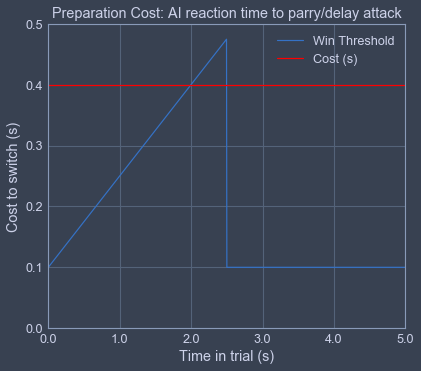

In [14]:
min_rt = 0.1
rt_penalty_scale = 0.15
trial_time = 5

def get_parry_rt(planned_attack_time):
    t = np.linspace(0,trial_time,1000)
    t[t>planned_attack_time] = 0
    parry_rt = t * rt_penalty_scale + min_rt
    return parry_rt

plt.plot(get_parry_rt(2.5))
axhline(0.4,color='red')
legend({'Cost (s)', 'Win Threshold'});
xlabel('Time in trial (s)');  xticks(np.linspace(0,1000,6), np.linspace(0,5,6));
ylabel('Cost to switch (s)');
title('Preparation Cost: AI reaction time to parry/delay attack');
xlim([0,1000]); ylim([0,0.5]);

From this, we see that there is a 'sweet-spot' for attacking the AI with a strike. This is when the AI's reaction time is above too slow to switch to parry (above the win threshold, between 2 and 2.5 sec). There are actually two sweet spots, one for attacking, one for parrying. We have only shown a theoretical for attacking since it is more simple. For parrying, the sweetspot can include both prior to and following the attack, depending on how the timings line up, since parrying is faster than attacking. The specifics depend on the timings selected, so it doesn't help much to go in depth here. Maybe in a future notebook, we can create the functions for doing such analyses with flexible timings.

## Next Up... Coming soon!